# Recommender System
This Matlab code has been completed as part of [Machine Learning](https://www.coursera.org/learn/machine-learning)
course in Coursera given by Prof. Andrew Ng

------------
This note demonstrates the implementation of the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. 

This notebook includes:
- <a href='#part1'>Part 1: The movie ratings dataset</a>
- <a href='#part2'>Part 2: PCA on Face Data</a>

This code requires the following functions
* <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_10_RecommenderSystems_cofiCostFunc.m'>funcs_10_RecommenderSystems_cofiCostFunc.m</a> 
* <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_fmincg.m'>funcs_fmincg.m</a> 

In [16]:
clear all; close all; clc; warning off;
addpath('../data/') % add path to directory containing data files
addpath('./funcs/') % add path to directory containing subfunction files

## Part 1: The movie ratings dataset <a id='part1'></a>

This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 
Loading movie ratings dataset:
* *Y* is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
* *R* is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i, otherwise R(i,j) = 0
* *moviesList* contains names of 1682 movies

Throughout this part of the exercise, you will also be working with the matrices, $X$ and $\Theta$:
 
$ X=
\begin{bmatrix}
    - & \left(x^{(1)}\right)^T &- \\
    - & \left(x^{(2)}\right)^T & - \\
      & ... &  \\
    - & \left(x^{(m)}\right)^T & -
\end{bmatrix} $; and  $ \Theta=
\begin{bmatrix}
    - & \left(\theta^{(1)}\right)^T &- \\
    - & \left(\theta^{(2)}\right)^T & - \\
      & ... &  \\
    - & \left(\theta^{(m)}\right)^T & -
\end{bmatrix} $

The i-th row of X corresponds to the feature vector $x^{(i)}$ for the i-th movie, and the j-th row of Theta corresponds to one parameter vector $\theta^{(j)}$ , for the j-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors.

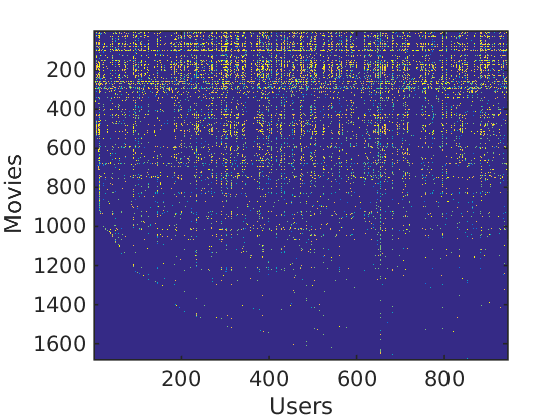

Average rating for movie 1 (Toy Story): 3.878319 / 5

In [17]:
load ('data_10_RecommenderSystems_movies.mat');

%  From the matrix, we can compute statistics like average rating.
fprintf('Average rating for movie 1 (Toy Story): %f / 5\n\n', mean(Y(1, R(1, :))));

%  We can "visualize" the ratings matrix by plotting it with imagesc
imagesc(Y);
ylabel('Movies');
xlabel('Users');

### Entering ratings for a new user

Before we will train the collaborative filtering model, we will first add ratings that correspond to a new user that we just observed. This part of the code will also allow you to put in your own ratings for the movies in our dataset.

In [18]:
%  Initialize my ratings
my_ratings = zeros(1682, 1);

% Check the file movie_idx.txt for id of each movie in our dataset
% For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings(1) = 4;

% Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings(98) = 2;

% We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings(7) = 3;
my_ratings(12)= 5;
my_ratings(54) = 4;
my_ratings(64)= 5;
my_ratings(66)= 3;
my_ratings(69) = 5;
my_ratings(183) = 4;
my_ratings(226) = 5;
my_ratings(355)= 5;

fprintf('\n\nNew user ratings:\n');
for i = 1:length(my_ratings)
    if my_ratings(i) > 0 
        fprintf('Rated %d for %s\n', my_ratings(i), movieList{i});
    end
end


New user ratings:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)

## Part 2: Collaborative filtering learning algorithm <a id='part2'></a>

We will start by implementing the cost function. The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)} , ..., x^{(n_m)}$ and $\theta^{(1)} , ..., \theta^{(n_u)}$ , where the model predicts the rating for movie i by user j as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors x^{(1)} , ..., x^{(n_m)}$ and $\theta^{(1)} , ..., \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).


The function <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_10_RecommenderSystems_cofiCostFunc.m'>funcs_10_RecommenderSystems_cofiCostFunc.m</a> compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are X and Theta. In order to use an off-the-shelf minimizer such as <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_fmincg.m'>funcs_fmincg.m</a>, the cost function has been set up to unroll the parameters into a single vector params.

#### Collaborative filtering cost function
The cost function for collaborative filtering with regularization is given by:

$$ J\left( x^{(1)} , ..., x^{(n_m)}, \theta^{(1)} , ..., \theta^{(n_u)}  \right) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u}\sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2 \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m}\sum_{k=1}^{n} \left( x_k^{(i)} \right)^2 \right)$$

#### Gradient
The gradients for the regularized cost function is given by:

$$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$\frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) x_k^{(i)} + \lambda \theta_k^{(j)} $$

The function <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_10_RecommenderSystems_cofiCostFunc.m'>funcs_10_RecommenderSystems_cofiCostFunc.m</a> should return $\left[\frac{\partial J}{\partial x_k^{(i)}}; \frac{\partial J}{\partial \theta_k^{(j)}} \right]$


In [19]:
fprintf('\nTraining collaborative filtering...\n');

%  Add our own ratings to the data matrix
Y = [my_ratings Y];
R = [(my_ratings ~= 0) R];

%  Normalize Ratings
[m, n] = size(Y);
Ymean = zeros(m, 1);
Ynorm = zeros(size(Y));
for i = 1:m
    idx = find(R(i, :) == 1);
    Ymean(i) = mean(Y(i, idx));
    Ynorm(i, idx) = Y(i, idx) - Ymean(i);
end

%  Useful Values
num_users = size(Y, 2);
num_movies = size(Y, 1);
num_features = 10;

% Set Initial Parameters (Theta, X)
X = randn(num_movies, num_features);
Theta = randn(num_users, num_features);

initial_parameters = [X(:); Theta(:)];

% Set options for fmincg
options = optimset('GradObj', 'on', 'MaxIter', 100);

% Set Regularization
lambda = 10;
theta = funcs_fmincg (@(t)(funcs_10_RecommenderSystems_cofiCostFunc(t, Y, R, num_users, num_movies, ...
    num_features, lambda)), initial_parameters, options);

% Unfold the returned theta back into U and W
X = reshape(theta(1:num_movies*num_features), num_movies, num_features);
Theta = reshape(theta(num_movies*num_features+1:end), num_users, num_features);

fprintf('Recommender system learning completed.\n');

Training collaborative filtering...
Last iteration ( 100 th) | Cost: 7.208276e+04
Recommender system learning completed.

###  Recommendations

After the additional ratings have been added to the dataset, the above algorithm will proceed to train the collaborative filtering model. This will learn the parameters X and Theta for the new input rating information. To predict the rating of movie i for user j, we need to compute $(\theta^{(j)})^T x^{(i)}$ . 

In [20]:
p = X * Theta';
my_predictions = p(:,1) + Ymean;

[r, ix] = sort(my_predictions, 'descend');
fprintf('\nTop recommendations for you:\n');
for i=1:10
    j = ix(i);
    fprintf('Predicting rating %.1f for movie %s\n', my_predictions(j), movieList{j});
end

fprintf('\n\nOriginal ratings provided:\n');
for i = 1:length(my_ratings)
    if my_ratings(i) > 0 
        fprintf('Rated %d for %s\n', my_ratings(i), movieList{i});
    end
end

Top recommendations for you:
Predicting rating 8.5 for movie Titanic (1997)
Predicting rating 8.4 for movie Shawshank Redemption, The (1994)
Predicting rating 8.4 for movie Star Wars (1977)
Predicting rating 8.2 for movie Schindler's List (1993)
Predicting rating 8.2 for movie Raiders of the Lost Ark (1981)
Predicting rating 8.1 for movie Good Will Hunting (1997)
Predicting rating 8.1 for movie Braveheart (1995)
Predicting rating 8.1 for movie Usual Suspects, The (1995)
Predicting rating 8.0 for movie Godfather, The (1972)
Predicting rating 7.9 for movie Empire Strikes Back, The (1980)


Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)